# Exploring venues in Houston, Texas, USA by leveraging Foursquare API and Zomato API
    - by Deep Patel

## 1. INTRODUCTION

### 1.1 Business Problem as an Objective

Houston, TX, USA is the place with the 4th largest Airport System in the United States and is also a primary gateway to Latin America. There were 10 million visitors to Houston in 2019. **Each new visitor is naturally expected to get confused regarding “What to eat?” and “Where to eat?”.** The person might want to know how good a given restaurant is i.e. rating or the price range it falls under i.e. price for two. **Combining the location of the venues in the city with their price and rating information and clustering them into different categories would surely help in making informed decisions about the venues one should go according to their cuisine preferences.**

### 1.2 Targeted Users

Houston is spread over 669 square miles. Being one of the largest tourist attractions due to Houston Museum of Natural Science, NASA's Space Center and Horse Riding, visitors spend a lot of money in food too. Thus, this project explores various venues with the attributes like location, rating and price for two to have a meal in a particular restaurant. This project involves the juxtaposition of both the Foursquare API and the Zomato API to fetch complete information (including name, address, category, rating, and price). Further, a map of the venues with specific color attributes will be plotted to highlight their position, and corresponding information. Such plots imbibe bountiful information in the form of their colored representations and location on the map. **This enables any visitor i.e. our main targeted users to take a quick glance and decide which venue is the best for them.**

## 2. DATA

### 2.1 Data to be used

- First, the coordinates of “Houston, Texas” obtained using geolocator of google.
- Second, feeding the coordinates to the Foursquare’s Explore API, details about the nearby recommended venues within a specified radius range i.e. 5 miles are fetched.
- Third, leveraging the Zomato API for the fetched venues in Second step, details about the ratings and price range are collected for each venue.

### 2.2 Data Sources

*Following are the detailed steps (shown with the code and output in methodology section):*

From **Foursquare API, using the EXPLORE request**, following information are retrieved for the recommended venues within 2-mile radius from Las Vegas Central point:
1.	Name: The name of the venue
2.	Category: The category type as defined by the API used for classification
3.	Latitude: The latitude value for the coordinates of the venue
4.	Longitude: The longitude value for the coordinates of the venue

From **Zomato API,** using the Detailed Information request for the venues listed in above step, following information are retrieved:
1.	Name: The name of the venue
2.	Address: The complete address of the venue
3.	Rating: The ratings provided by the users
4.	Price Range: Estimated price range that the venue belongs to as per Zomato
5.	Price for two: Estimated cost for the average meal of two people – excluding drinks and tips/tax
6.	Latitude: The latitude value for the coordinates of the venue
7.	Longitude: The longitude value for the coordinates of the venue

**Joining the two above datasets on the basis of common features i.e. either Name, Latitude or Longitude, will give us the required data and conclude the data preparation part.**


## 3. METHODOLOGY

In [1]:
# Let's first import all the required libraries and dependencies:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests #library to reuqest result of the source webpage
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


### 3.1 Data Preparation

**First, Getting the coordinates for Houston, Texas**

**Below is the Highlighted Cell where any city name, state can be entered as per the user**

In [2]:
address = 'Houston, Texas'

In [3]:
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
h_latitude = location.latitude
h_longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, h_latitude, h_longitude))

The geograpical coordinate of Houston, Texas are 29.7589382, -95.3676974.


**Second, feeding the coordinates to the Foursquare’s Explore API, details about the nearby recommended venues within a specified radius range i.e. 5 miles are fetched.**

In [4]:
# @hidden_cell

# define Foursquare Credentials and Version
CLIENT_ID = 'KCNPI2QUTDQRVJITAU0XYICWKQZXVZCE2Y15O2GGV5KMFQZ3' # your Foursquare ID
CLIENT_SECRET = 'SZ5JSSRTQY2TNJWOEOYUZFQVYGE2IJMIKQMPW4FKD3J10ICS' # your Foursquare Secret
VERSION = '20200401' # Foursquare API version i.e. current date

radius = 8047 #5miles in meters
LIMIT = 200 #limit of venues=100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    h_latitude, 
    h_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=KCNPI2QUTDQRVJITAU0XYICWKQZXVZCE2Y15O2GGV5KMFQZ3&client_secret=SZ5JSSRTQY2TNJWOEOYUZFQVYGE2IJMIKQMPW4FKD3J10ICS&v=20200401&ll=29.7589382,-95.3676974&radius=8047&limit=200'

Above in the hidden cell I have loaded my API credentials and now will be making the request calls.

In [5]:
results = requests.get(url).json()
# results

In [6]:
#define the function to get the category type 100
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        h_latitude,
                                                                        h_longitude,  
                                                                        radius,
                                                                        LIMIT,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, radius/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 8.047 Km
Total 100 venues fetched within a total radius of 8.047 Km
Total 42 venues fetched within a total radius of 8.047 Km

Total 242 venues fetched


In [8]:
foursquare_venues['venue'] = foursquare_venues['name']
print(foursquare_venues.shape)
foursquare_venues.head()

(242, 5)


,name,categories,lat,lng,venue
0,Wortham Theater Center,Theater,29.763353,-95.365663,Wortham Theater Center
1,Hobby Center for the Performing Arts,Performing Arts Venue,29.761526,-95.369376,Hobby Center for the Performing Arts
2,Alley Theatre,Theater,29.761671,-95.365313,Alley Theatre
3,House of Blues,Music Venue,29.753836,-95.363932,House of Blues
4,Conservatory,Beer Garden,29.760427,-95.361570,Conservatory


**Point to Note**: In the above dataset of venues fetched one can see that there are some Museums and Theaters too. But, we don't need to worry about them for now. **The reason is, Zomato API will only provide details for the venues which comes under food serving categories and for the rest we will not get anything and can be dropped easily. You will see how!!**

In [9]:
map = folium.Map(location = [h_latitude, h_longitude], zoom_start = 12)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map)  
# map.save("FSMap.html")
map

**Third, leveraging the Zomato API for the fetched venues in Second step, details about the ratings and price range are collected for each venue.**

In [10]:
# @hidden_cell
headers = {'user-key': '01cad1eabf77a95e7158ecdcbef82a29'}

In [11]:
venues_information = []

for index, row in foursquare_venues.iterrows():
#     print("Getting for" + str(index+1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(float(result['restaurants'][0]['restaurant']['location']['latitude']))
        venue.append(float(result['restaurants'][0]['restaurant']['location']['longitude']))
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

In [12]:
print(zomato_venues.shape)
zomato_venues.head()

(242, 7)


,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Artista,29.76177,-95.36879,90.0,4.0,3.6,"800 Bagby Street, Suite 400, Hobby Center of t..."
1,Artista,29.76177,-95.36879,90.0,4.0,3.6,"800 Bagby Street, Suite 400, Hobby Center of t..."
2,0,0.00000,0.00000,0.0,0.0,0,None
3,House of Blues Restaurant & Bar,29.75391,-95.36358,70.0,4.0,2.6,1204 Caroline Street 77002
4,Conservatory Underground Beer Garden & Food Hall,29.76062,-95.36191,0.0,1.0,3.4,1010 Prairie Street 77002


In [13]:
map1 = folium.Map(location = [h_latitude, h_longitude], zoom_start = 12)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.5,
        parse_html = False).add_to(map1)  

# map1.save("ZOMap.html")
map1

### 3.2 Data Cleaning

**Main Objectives:**
1. Filter the venues to keep only restaurants and food places
2. Merge Foursquare_venues and Zomato_venues to create a final dataset
3. Remove the fruitless venues i.e. Venues with no ratings, venues with no price details
4. Drop the columns that are common in both the API's result sets
5. Drop duplicates if any

**Step 1: Filter the venues to keep only restaurants and food places**
In the above dataset fetched using Zomato API, for the venues in the FOURSQUARE API dataset which were NOT restaurants or food places, all the values are set to 0 or none. Let us get rid of them

In [14]:
zomato_venues = zomato_venues[zomato_venues.venue != 0].reset_index(drop=True)
print("Now we have " + str(zomato_venues.shape[0]) +" venues in Zomato's venue dataset")

Now we have 234 venues in Zomato's venue dataset


**Step 2: Merge Foursquare_venues and Zomato_venues to create a final dataset**
Merging both the dataset on the basis of matching names of venues so that details don't get mismatched.

In [15]:
merged_venues = pd.merge(foursquare_venues, zomato_venues, on='venue')

In [16]:
print(merged_venues.shape)
merged_venues.head(3)

(137, 11)


,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Flying Saucer Draught Emporium,Beer Bar,29.759116,-95.363216,Flying Saucer Draught Emporium,29.758893,-95.363106,50.0,4.0,4.5,"705 Main Street, Suite A, Houston 77002"
1,Frank's Pizza,Pizza Place,29.761393,-95.362721,Frank's Pizza,29.761303,-95.362416,25.0,2.0,4.3,"417 Travis Street, Houston 77002"
2,La Carafe,Wine Bar,29.763041,-95.361904,La Carafe,29.763133,-95.361827,35.0,3.0,2.0,"813 Congress Avenue, Houston 77002"


Above merged dataset will have lesser venues because only the venues present in both the datasets will be added.

**Step 3: Remove the fruitless venues i.e. Venues with no ratings, venues with no price details**
In the above, there are some venues having **0 as rating** and obviously no one would like to go to these particular restaurants. There are some restaurants having **0 as price**. Presence of these venues can affect our later statistical analysis. **Let's remove all the venues with rating = 0 and price = 0**

In [17]:
merged_venues = merged_venues[merged_venues.rating != 0].reset_index(drop=True)
merged_venues = merged_venues[merged_venues.price_for_two != 0].reset_index(drop=True)
print(merged_venues.shape)
merged_venues.head(3)

(113, 11)


,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Flying Saucer Draught Emporium,Beer Bar,29.759116,-95.363216,Flying Saucer Draught Emporium,29.758893,-95.363106,50.0,4.0,4.5,"705 Main Street, Suite A, Houston 77002"
1,Frank's Pizza,Pizza Place,29.761393,-95.362721,Frank's Pizza,29.761303,-95.362416,25.0,2.0,4.3,"417 Travis Street, Houston 77002"
2,La Carafe,Wine Bar,29.763041,-95.361904,La Carafe,29.763133,-95.361827,35.0,3.0,2.0,"813 Congress Avenue, Houston 77002"


**Step 4: Drop the columns that are common in both the API's result sets**
We will drop the columns namely **name, lat, long**

In [18]:
result = merged_venues.drop(columns = ['name', 'lat', 'lng'])
print(result.shape)
result.head(3)

(113, 8)


,categories,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Beer Bar,Flying Saucer Draught Emporium,29.758893,-95.363106,50.0,4.0,4.5,"705 Main Street, Suite A, Houston 77002"
1,Pizza Place,Frank's Pizza,29.761303,-95.362416,25.0,2.0,4.3,"417 Travis Street, Houston 77002"
2,Wine Bar,La Carafe,29.763133,-95.361827,35.0,3.0,2.0,"813 Congress Avenue, Houston 77002"


In [19]:
result = result.drop_duplicates(subset = ["venue"])
print(result.shape)
result.head(3)

(75, 8)


,categories,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Beer Bar,Flying Saucer Draught Emporium,29.758893,-95.363106,50.0,4.0,4.5,"705 Main Street, Suite A, Houston 77002"
1,Pizza Place,Frank's Pizza,29.761303,-95.362416,25.0,2.0,4.3,"417 Travis Street, Houston 77002"
2,Wine Bar,La Carafe,29.763133,-95.361827,35.0,3.0,2.0,"813 Congress Avenue, Houston 77002"


### Our final dataset `result`, after all wrangling and cleansing done, is ready for the analysis part. Let's dive in.

### 3.3 Analysis
**Main Objectives:**
1. Venue's `Category` based analysis
2. Venue's `Rating` based analysis
3. Rating wise venue map
4. Venue's `Price for Two` based analysis
5. `Price for Two` wise venue map
6. K-means Clustering of the venues

**Step 1: Venue's `Category` based analysis**

<BarContainer object of 40 artists>

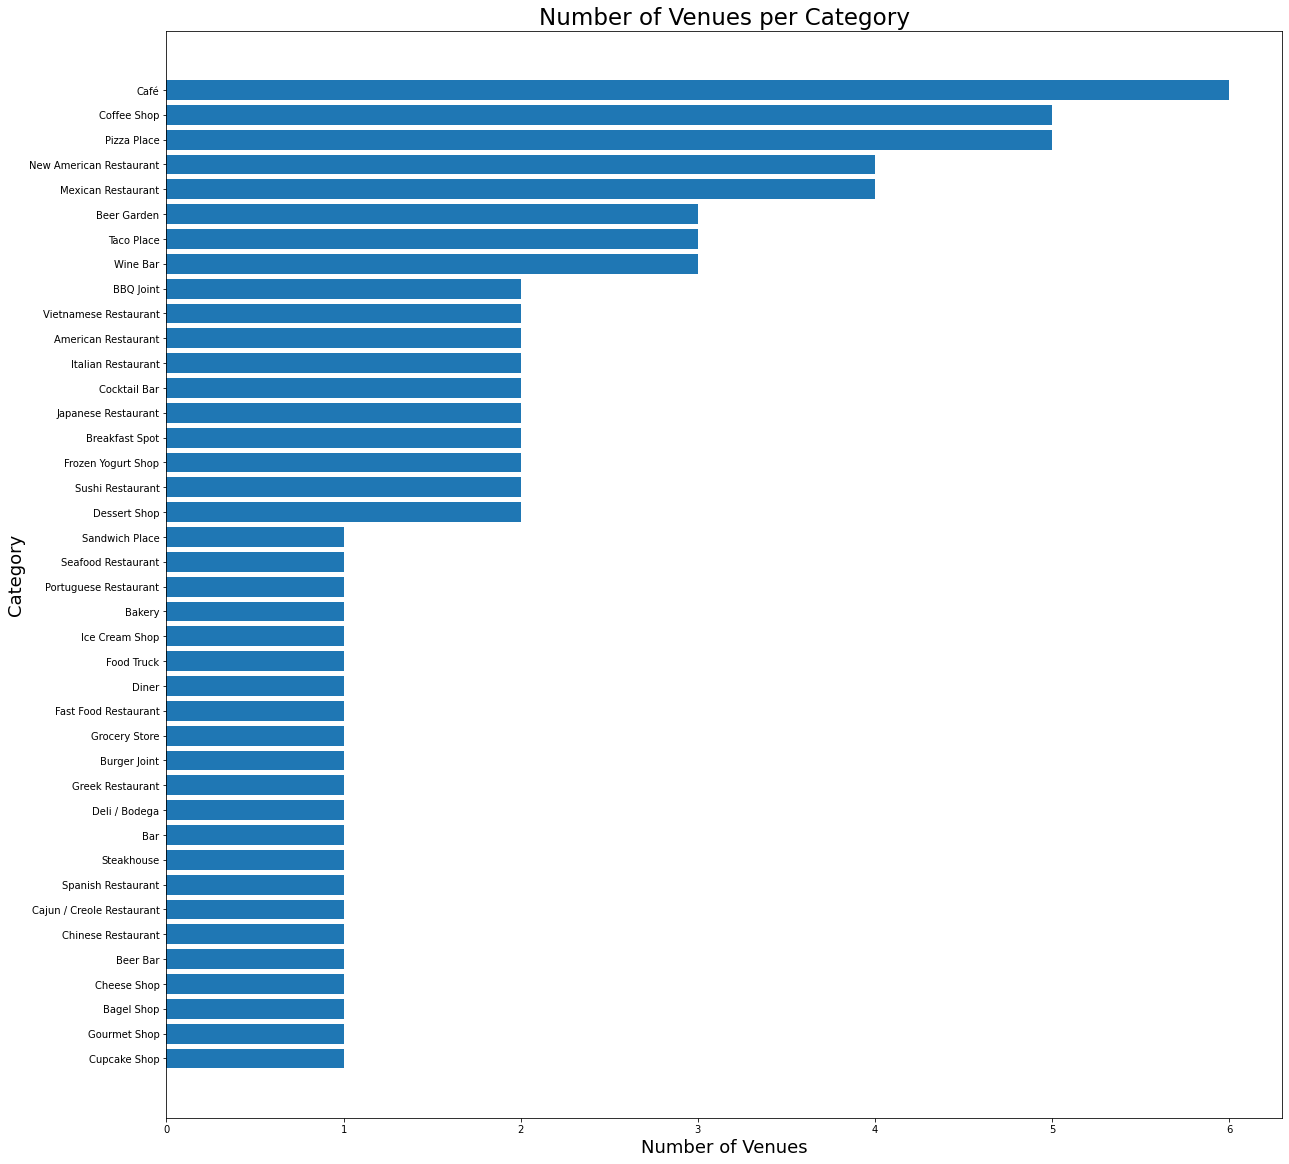

In [20]:
venue_segmentation = result['categories'].value_counts()
venue_segmentation = venue_segmentation[::-1]
# colors = cm.rainbow(np.linspace(0, 1, len(venue_segmentation.index)))
plt.figure(figsize = (20, 20))
plt.xlabel("Number of Venues", fontsize = 18)
plt.ylabel("Category", fontsize = 18)
plt.title("Number of Venues per Category", fontsize = 23)
plt.barh(venue_segmentation.index, venue_segmentation.values)

# plt.savefig("category.png", bbox_inches='tight', dpi=300)

**Step 2: Venue's `Rating` based analysis**

Text(0.5, 1.0, 'Count of venues with given rating')

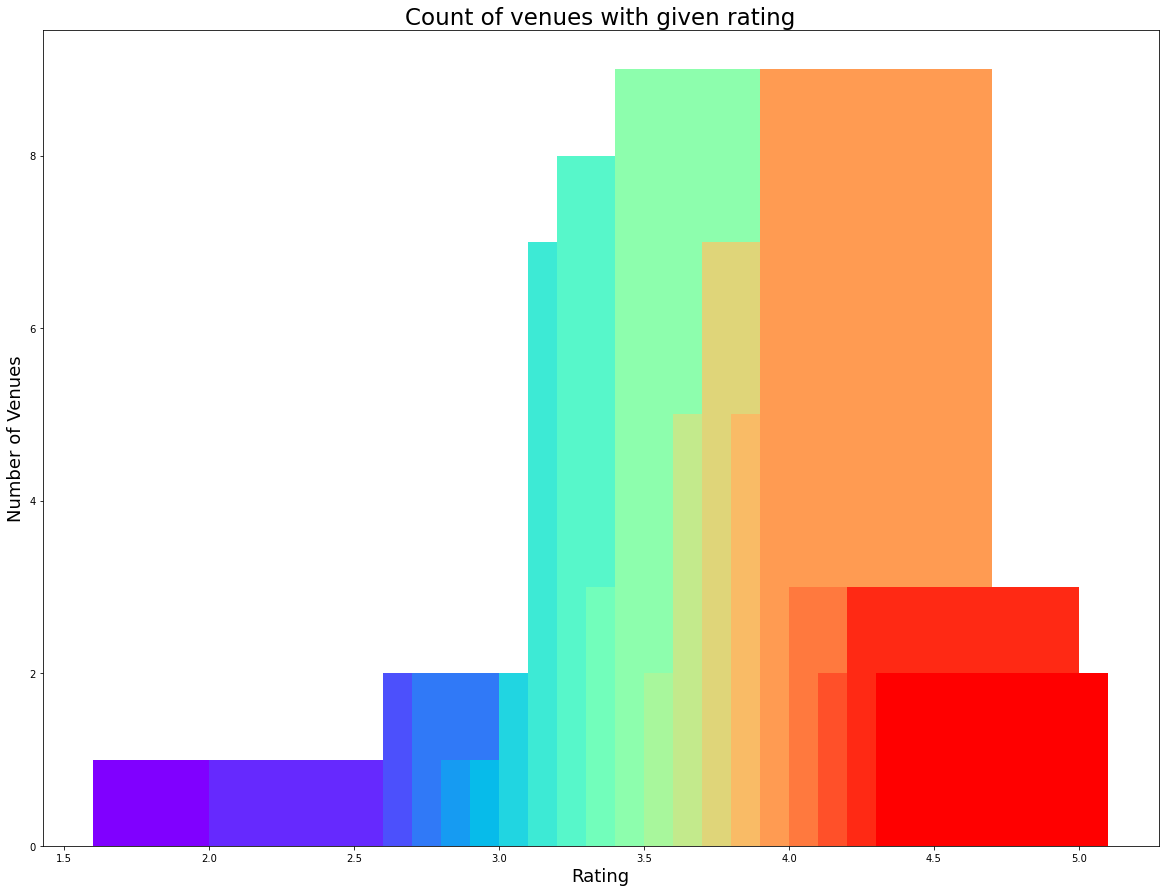

In [21]:
result['rating'] = result['rating'].astype(float)
ratings = result['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 15))
plt.bar(ratings.index, ratings.values, color = cm.rainbow(np.linspace(0, 1, len(ratings.index))))
plt.xlabel("Rating", fontsize = 18)
plt.ylabel("Number of Venues", fontsize = 18)
plt.title("Count of venues with given rating", fontsize = 23)
# plt.savefig("rating.png", bbox_inches='tight', dpi=300)

**Step 3: Rating wise venue map**

Let us first create rating distribution as follows:

| Rating Value | Rating Comment | Color in Map |
|:-:|:-:|:-:
| 0.0-1.0      | Poor           | Dark Blue    |
| 1.1-2.0      | Low            | Blue         |
| 2.1-3.0      | Average        | Light Blue   |
| 3.1-4.0      | Good           | Green        |
| 4.1-5.0      | Very Good      | Light Green  |

In [22]:
bins = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Poor','Low', 'Average', 'Good', 'Very good']
result['rating_bin'] = pd.cut(result['rating'].astype(float), bins = bins, labels = labels, include_lowest = False)

In [23]:
color_map = {'Poor': 'darkblue', 'Low': 'blue', 'Average': 'lightblue', 'Good': 'green', 'Very good': 'darkgreen'}

ratingmap = folium.Map(location = [h_latitude, h_longitude], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(result['venue'], 
                                                          result['address'], 
                                                          result['latitude'], 
                                                          result['longitude'], 
                                                          result['rating_bin']):
    label = '{}, {}. {}'.format(name, address, rating_bin)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(ratingmap)  
ratingmap.save("RATINGMap.html")
ratingmap

**Step 4: Venue's `Price for Two` based analysis**

Text(0.5, 1.0, 'Count of Venues with given price per two people for average meal')

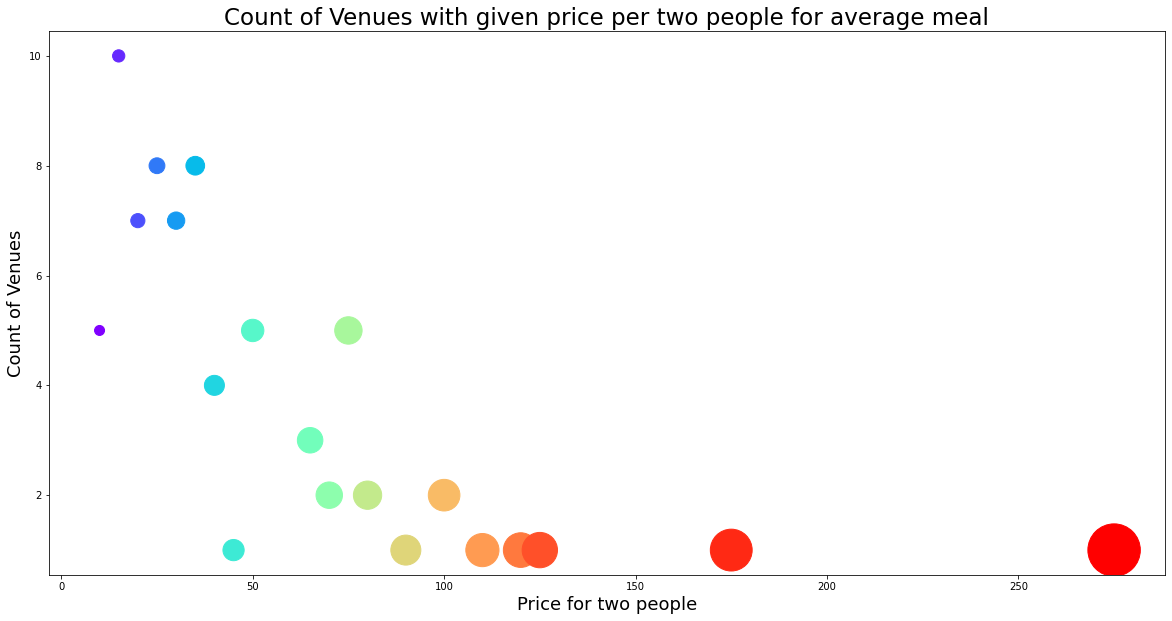

In [24]:
prices = result['price_for_two'].value_counts().sort_index()
plt.figure(figsize = (20, 10))
plt.scatter(prices.index, prices.values, s = prices.index*10, c = cm.rainbow(np.linspace(0, 1, len(prices.index))))
plt.xlabel("Price for two people", fontsize = 18)
plt.ylabel("Count of Venues", fontsize = 18)
plt.title("Count of Venues with given price per two people for average meal", fontsize = 23)
# plt.savefig("pricefortwo.png", bbox_inches='tight', dpi=300)

**Step 5: `Price for Two` wise venue map**

Let us first create Price distribution as follows:

| Price_for_two's Value | Price Comment  | Color in Map |
|-----------------------|:---------------|:-------------|
| 0.0-25.0              | Low price      | Dark Green   |
| 25.1-50.0             | Moderate Price | Green        |
| 50.0-100.0            | Expensive      | Light Blue   |
| 100.1 and above       | Very expensive | Blue         |

In [25]:
pricebins = [0.0, 25.0, 50.0, 100.0, 500.0]
pricelabels = ['Low Price','Moderate Price', 'Expensive', 'Very Expensive']
result['price_bin'] = pd.cut(result['price_for_two'].astype(float), bins = pricebins, labels = pricelabels, include_lowest = False)

In [26]:
color_map = {'Low Price': 'darkgreen', 'Moderate Price': 'green', 'Expensive': 'lightblue', 'Very Expensive': 'blue'}

pricemap = folium.Map(location = [h_latitude, h_longitude], zoom_start = 12)

for name, latitude, longitude, price, price_bin in zip(result['venue'],  
                                                     result['latitude'], 
                                                     result['longitude'], 
                                                     result['price_for_two'],
                                                     result['price_bin']):
    label = '{}, {}. {}'.format(name, price, price_bin)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_bin]),
        popup = label).add_to(pricemap)
# pricemap.save("PRICEMap.html")
pricemap

**Step 6: K-means Clustering of the venues**

In [27]:
clustering = result.drop(['venue', 'categories', 'address', 'rating_bin', 'price_bin'], 1)

In [28]:
NO_OF_CLUSTERS = 3
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
result.insert(0, 'cluster_labels', kMeans.labels_)
result.head(3)

,cluster_labels,categories,venue,latitude,longitude,price_for_two,price_range,rating,address,rating_bin,price_bin
0,2,Beer Bar,Flying Saucer Draught Emporium,29.758893,-95.363106,50.0,4.0,4.5,"705 Main Street, Suite A, Houston 77002",Very good,Moderate Price
1,2,Pizza Place,Frank's Pizza,29.761303,-95.362416,25.0,2.0,4.3,"417 Travis Street, Houston 77002",Very good,Low Price
2,2,Wine Bar,La Carafe,29.763133,-95.361827,35.0,3.0,2.0,"813 Congress Avenue, Houston 77002",Low,Moderate Price


In [29]:
clustermap = folium.Map(location = [h_latitude, h_longitude], zoom_start = 13)
color_map = { 0: 'blue', 1: 'red', 2: 'green' }

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(result['venue'], 
                                                        result['address'], 
                                                        result['cluster_labels'], 
                                                        result['latitude'], 
                                                        result['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(clustermap)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(clustermap)
# clustermap.save("clustermap.html")
clustermap

In [30]:
cluster1 = result.loc[result['cluster_labels'] == 0]
cluster1.head(3)

,cluster_labels,categories,venue,latitude,longitude,price_for_two,price_range,rating,address,rating_bin,price_bin
3,0,New American Restaurant,Hearsay Gastro Lounge,29.763046,-95.361624,65.0,4.0,4.1,"218 Travis Street, Houston 77002",Very good,Expensive
9,0,Wine Bar,13 Celsius,29.741254,-95.373768,100.0,4.0,4.0,3000 Caroline Street 77004,Good,Expensive
10,0,Cocktail Bar,Weights + Measures,29.742636,-95.372765,80.0,4.0,3.7,2808 Caroline Street 77004,Good,Expensive


In [37]:
print("The {} venues present in CLUSTER 1 have average PRICE FOR TWO= {:.02f} (min={:.02f}, max={:.02f}) \nwith the average RATING= {:.02f} (min={:.02f}, max={:.02f})".
      format(cluster1.shape[0],cluster1['price_for_two'].mean(), cluster1['price_for_two'].min(), cluster1['price_for_two'].max(), cluster1['rating'].mean(), cluster1['rating'].min(), cluster1['rating'].max()))

The 18 venues present in CLUSTER 1 have average PRICE FOR TWO= 84.17 (min=65.00, max=125.00) 
with the average RATING= 3.94 (min=3.00, max=4.70)


In [32]:
cluster2 = result.loc[result['cluster_labels'] == 1]
cluster2.head(3)

,cluster_labels,categories,venue,latitude,longitude,price_for_two,price_range,rating,address,rating_bin,price_bin
85,1,New American Restaurant,State of Grace,29.742493,-95.425205,275.0,4.0,3.6,3256 Westheimer Road 77098,Good,Very Expensive
90,1,Steakhouse,Brenner's on the Bayou,29.759546,-95.419914,175.0,4.0,3.8,1 Birdsall Street 77007,Good,Very Expensive


In [38]:
print("The {} venues present in CLUSTER 2 have average PRICE FOR TWO= {:.02f} (min={:.02f}, max={:.02f}) \nwith the average RATING= {:.02f} (min={:.02f}, max={:.02f})".
      format(cluster2.shape[0], cluster2['price_for_two'].mean(), cluster2['price_for_two'].min(), cluster2['price_for_two'].max(), cluster2['rating'].mean(), cluster2['rating'].min(), cluster2['rating'].max()))

The 2 venues present in CLUSTER 2 have average PRICE FOR TWO= 225.00 (min=175.00, max=275.00) 
with the average RATING= 3.70 (min=3.60, max=3.80)


In [34]:
cluster3 = result.loc[result['cluster_labels'] == 2]
cluster3.head(3)

,cluster_labels,categories,venue,latitude,longitude,price_for_two,price_range,rating,address,rating_bin,price_bin
0,2,Beer Bar,Flying Saucer Draught Emporium,29.758893,-95.363106,50.0,4.0,4.5,"705 Main Street, Suite A, Houston 77002",Very good,Moderate Price
1,2,Pizza Place,Frank's Pizza,29.761303,-95.362416,25.0,2.0,4.3,"417 Travis Street, Houston 77002",Very good,Low Price
2,2,Wine Bar,La Carafe,29.763133,-95.361827,35.0,3.0,2.0,"813 Congress Avenue, Houston 77002",Low,Moderate Price


In [39]:
print("The {} venues present in CLUSTER 3 have average PRICE FOR TWO= {:.02f} (min={:.02f}, max={:.02f}) \nwith the average RATING= {:.02f} (min={:.02f}, max={:.02f})".
      format(cluster3.shape[0], cluster3['price_for_two'].mean(), cluster3['price_for_two'].min(), cluster3['price_for_two'].max(), cluster3['rating'].mean(), cluster3['rating'].min(), cluster3['rating'].max()))

The 55 venues present in CLUSTER 3 have average PRICE FOR TWO= 27.00 (min=10.00, max=50.00) 
with the average RATING= 3.85 (min=2.00, max=4.70)


## 4. RESULTS AND DISCUSSION

### 4.1 Results

After collecting data from the Foursquare and Zomato APIs for Houston, Texas; we got a list of 240 different venues. However, not all venues from the two different APIs were identical. Hence, after inspecting the two datasets separately, **two datasets were merged on the basis of matching names of the venues.** *Latitude and Longitude can also be used as matching criteria, but in this case they were not used because of the differences in their values.*

`Following are the results of the analysis:`

1. From the Category analysis, it is identified that majority of the venues were Pizza Places and Cafes followed by Beer Gardens and Mexican restaurants and Indian Restaurants.
<p>&nbsp;</p>
2. Rating analysis clearly depicts that majority of the venues have good ratings i.e. 3.5 to 4.0 and at least 3rd quarter of the venues have their ratings above 3.5. Mapping the venues with the corresponding Rating Indicator, it is found that all the venues between Westheimer Road and Bissonnette Street have ‘Very Good’ and ‘Good’ rating values i.e. above 3.0 for sure.  
<p>&nbsp;</p>
3. From the Price for two analysis, it is deduced that majority of the venues can provide average meal for two people at the cost lower than 50 and very few venues can be considered expensive. Mapping the venues with the corresponding Price Indicator, one can say that venues between West Gary Street and Southwest Freeway are pocket friendly.

## 5. CONCLUSION

Purpose of this project was to leverage FOURSQUARE API to get the venues within 5 miles of the center of Houston, Texas. All these venues were fed to ZOMATO API to get the ratings and price details for the restaurants and food serving venues. These were later on analyzed and grouped into 3 clusters shown above. **These findings can help the visitor's find the best dining place for him/her as per their venue rating and price preferences.**

This project can even be extended as **a Restaurant Recommendation System** to recommend the restaurants on the basis of mentioned Rating's range and Price's Range by the user. All needed is to **feed the location i.e. "city name, state" in the highlighted location cell.**